<a href="https://colab.research.google.com/github/steniodeassis/capstone/blob/main/capstone_LSTM_model_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset
The dataset is computed from two experiements with migration of cranial neural crest cells (CNCCs) in different EFs of various strenghts.

## Variables
- track: cell number
- slice: time steps (5 min interval)
- x: x position (assumed to be in mm)
- y: y position (mm)
- cum_dist: cummulative Euclidian distance (mm)
- euc_dist: total distance between origin and current position (mm)
- speed: instaneous speed (mm/min) between time steps
- cum_dir: cummulative directedness (cos of angle between electric field and direction of migration)
- ef: electric field (mV/mm)
- set: experiment (1 or 2)
- volt: voltage (V)

In [ ]:
import pandas as pd
import numpy as np
import math
from keras import backend as K
from keras.models import Sequential
from keras.models import load_model
from keras.layers import LSTM,Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/sargent et al (2022)/cncc.csv')

df['volt'] = df['ef'] / 1000 #distance of 1e-3 m

df2 = df.loc[df['set']==2]
df = df.loc[df['set']==1]


df = df[['track', 'slice', 'x', 'y', 'cum_dir', 'ef', 'volt']]
print(df.shape)


(12987, 7)


In [ ]:
df

,track,slice,x,y,cum_dir,ef,volt
0,1.0,1.0,0.000,0.000,0.000000,0,0.0
1,1.0,2.0,8.245,1.178,0.989947,0,0.0
2,1.0,3.0,7.067,-1.178,0.986390,0,0.0
3,1.0,4.0,16.490,2.356,0.989947,0,0.0
4,1.0,5.0,27.090,7.067,0.967617,0,0.0
...,...,...,...,...,...,...,...
12982,50.0,33.0,-127.650,-21.202,-0.986485,200,0.2
12983,50.0,34.0,-130.742,-24.735,-0.982570,200,0.2
12984,50.0,35.0,-135.159,-26.502,-0.981313,200,0.2
12985,50.0,36.0,-135.601,-30.036,-0.976336,200,0.2


In [ ]:
#
#creates dataset to use for training/testing - updated scaling
def create_dataset(df, lookback=20, in_cols=['volt', 'cum_dir'], out_cols='cum_dir', efs=[0,15,30,50,75,100,200], tracks=(1,51)):
    trainX, trainY, = [], [] #lists of training and testing inputs/outputs
    for ef in efs:
        for track in range(tracks[0], tracks[1]): # training the model by ef and track
            cell = df.loc[(df["track"] == track)&(df["ef"] == ef)] #all rows of data pertaining to this cell
            cell = cell[in_cols] #reduce it to our columns of interest
            for i in range(len(cell)-lookback-1):
                trainX.append(cell[i:i+lookback]) #adding training groups w overlapping
            cell = cell[out_cols]
            for i in range(len(cell)-lookback-1):
                trainY.append(cell[i+lookback:i+lookback+1]) # one single Y for lookbacks size X (20:1)

    trainX = np.array(list(map(lambda x: x.to_numpy(), trainX)))
    trainY = np.array(list(map(lambda x: x.to_numpy(), trainY)))
    return np.array(trainX), np.array(trainY)

In [ ]:

# interested only efs=[0,50, 100,200]
efs = [0, 50, 100, 200]
# efs = [0, 15, 30, 50, 75, 100, 200]
trainX, trainY = create_dataset(df,efs=efs, tracks=(1,41))
valX, valY = create_dataset(df, efs=efs, tracks=(41,51))
testX, testY = create_dataset(df2, efs=efs, tracks=(1,51))

print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(2560, 20, 2)
(2560, 1)
(640, 20, 2)
(640, 1)
(3200, 20, 2)
(3200, 1)


In [ ]:
#trains numerous models using a list of numbers to initialize the models
def typical_model(trainX,trainY,valX,valY,testX,testY,numbers):
    models = [] #list of models
    predictions = [] #list of prediction vectors

    for i in numbers:
        #build the model
        print('Training model number {}'.format(i))
        model = Sequential()
        model.add(LSTM(80, input_shape=(20, 2)))
        model.add(Dense(1, activation='tanh'))
        model.compile(loss='mean_squared_error', optimizer='adam')
        history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=100, batch_size=1, verbose=1)
        models.append(model)

        model.save("models/cncc_lstm/model{}.h5".format(i))
        print("Saved model {} to disk".format(i))

        #Predict on training, validation, and test sets
        trainPredict = model.predict(trainX)
        valPredict = model.predict(valX)
        testPredict = model.predict(testX)

        #Calculate RMSEs
        trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
        print('Training RMSE: {}'.format(trainScore))
        valScore = math.sqrt(mean_squared_error(valY, valPredict))
        print('Validation RMSE: {}'.format(valScore))
        testScore = math.sqrt(mean_squared_error(testY, testPredict))
        print('Testing RMSE: {}'.format(testScore))

        #make predictions on each instance and add to list of prediction vectors
        train_pred = model.predict(trainX)
        val_pred = model.predict(valX)
        test_pred = model.predict(testX)
        preds = np.concatenate([train_pred,val_pred,test_pred], axis=None)
        predictions.append(preds)

    #find the average of all prediction vectors (for all models)
    mean_pred = np.mean(predictions,axis=0)

    #find the prediction vector that is closest to the mean
    closest = 0 #index of the prediction vector that is closest to the mean
    dist = 100 #the distance of that closest vector to the mean vector (maybe np.infty?)
    for i in range(len(predictions)):
        thisdist = math.sqrt(mean_squared_error(predictions[i], mean_pred))

        print('Model number: {}, distance from mean: {}'.format(i,thisdist))

        if thisdist < dist:
            dist = thisdist
            closest = i

    #return the "most average" model
    print('Returning model {}, whose distance is {}'.format(closest,dist))
    return models, closest

In [ ]:
number_models = 1 # 10 before

In [ ]:
models, closest = typical_model(trainX,trainY,valX,valY,testX,testY,range(number_models))
model = models[closest]

Training model number 0
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0373 - val_loss: 0.0116
Epoch 2/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0100 - val_loss: 0.0071
Epoch 3/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0079 - val_loss: 0.0073
Epoch 4/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0082 - val_loss: 0.0046
Epoch 5/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0103 - val_loss: 0.0052
Epoch 6/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0065 - val_loss: 0.0054
Epoch 7/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0065 - val_loss: 0.0050
Epoch 8/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 9/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 10/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 11/100
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.0048 - val_loss: 0.0053
Epoch 12/100
2560/25

Saved model 0 to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training RMSE: 0.04631326304474929
Validation RMSE: 0.08013826910824838
Testing RMSE: 0.09341905574251808
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Model number: 0, distance from mean: 0.0
Returning model 0, whose distance is 0.0


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 80)                  │          26,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              81 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,925 (312.21 KB)

 Trainable params: 26,641 (104.07 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,284 (208.14 KB)

In [ ]:
model.save("models/cncc_lstm.keras")
print("Saved model to disk")

Saved model to disk


In [ ]:
# save prediction for the best model
# for s in [1]:
for ef in efs:
    for track in range(1,51):
        cell = df.loc[(df['ef']==ef) & (df['track']==track)]
        for sl in range(21,38):
            print('ef: {}, track: {}, slice: {}'.format(ef,track,sl))
            x = cell.loc[(cell['slice']>sl-21) & (cell['slice']<sl)]
            x = x[['volt','cum_dir']].to_numpy()
            x=x.reshape(1, 20, 2)
            df.loc[(df['ef']==ef) & (df['track']==track) & (df['slice']==sl), 'pred_dir'] = model.predict(x)

df=df.drop('Unnamed: 0', axis=1)
df['pred_error'] = df['pred_dir'] - df['cum_dir']
df.to_csv('data/cncc_predictions.csv', index=False)
df.head(40)

Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
ef: 50, track: 4, slice: 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
ef: 50, track: 4, slice: 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
ef: 50, track: 4, slice: 23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
ef: 50, track: 4, slice: 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
ef: 50, track: 4, slice: 25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
ef: 50, track: 4, slice: 26
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
ef: 50, track: 4, slice: 27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
ef: 50, track: 4, slice: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
ef: 50, track: 4, slice: 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ef: 50, track: 4, slice: 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ef: 50, track: 4, slice: 31
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
ef: 50, track: 4, slice: 32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
ef: 50, track: 4, slice: 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
ef: 50, track: 4, slice: 34
1/1 ━━━━━━━━━━━━━━━━━━━━ 

KeyError: "['Unnamed: 0'] not found in axis"

In [ ]:
df.to_csv('cncc_data.csv')

In [ ]:
df.to_csv('data/cncc_predictions.csv', index=False)
df

OSError: Cannot save file into a non-existent directory: 'data'

<ipython-input-20-e0dfcc1a4f46>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['True cum_dir', 'Predicted cum_dir'])
<ipython-input-20-e0dfcc1a4f46>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['True cum_dir', 'Predicted cum_dir'])
<ipython-input-20-e0dfcc1a4f46>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['True cum_dir', 'Predicted cum_dir'])
<ipython-input-20-e0dfcc1a4f46>:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['True cum_dir', 'Predicted cum_dir'])


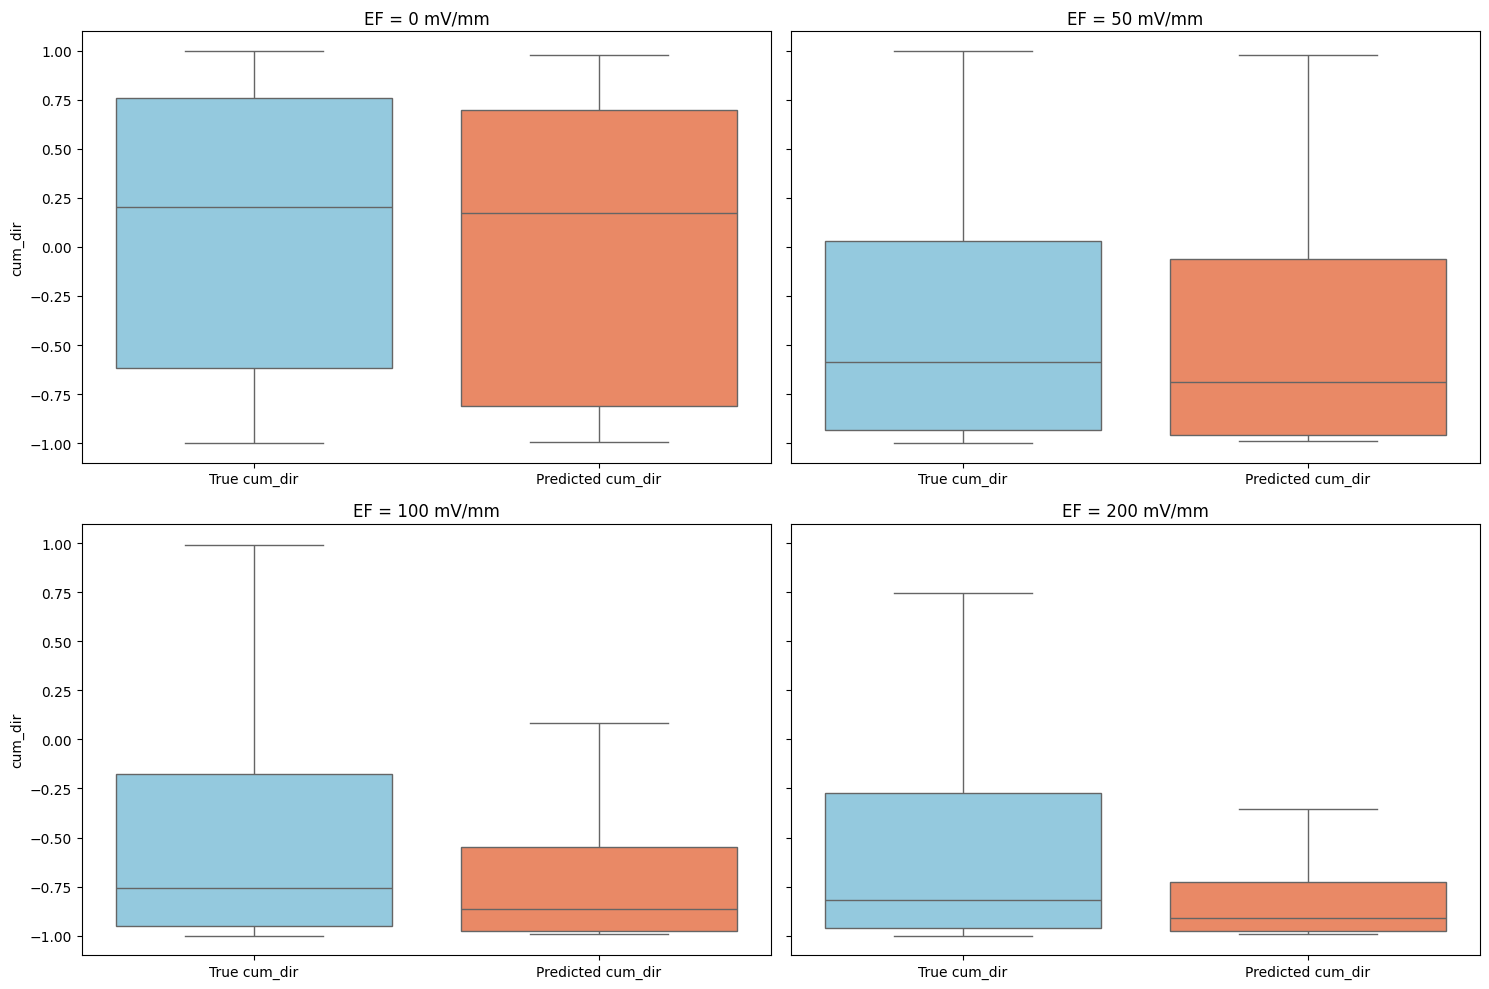

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load the dataframe
df = pd.read_csv('cncc_predictions.csv')

# Define the electric field values
efs = [0, 50, 100, 200]


# Create a figure and axes for the box plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each ef value
for i, ef in enumerate(efs):
    # Filter the dataframe for the current ef value
    df_ef = df[df['ef'] == ef]

    # Create a box plot for true and predicted cum_dir
    sns.boxplot(
        data=df_ef[['cum_dir', 'pred_dir']],
        ax=axes[i],
        palette=['skyblue', 'coral'],
        showfliers=False
    )
    axes[i].set_title(f'EF = {ef} mV/mm')
    axes[i].set_xticklabels(['True cum_dir', 'Predicted cum_dir'])
    axes[i].set_ylabel('cum_dir')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

<ipython-input-19-7f98477c86b9>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['True cum_dir', 'Predicted cum_dir'])
<ipython-input-19-7f98477c86b9>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['True cum_dir', 'Predicted cum_dir'])
<ipython-input-19-7f98477c86b9>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['True cum_dir', 'Predicted cum_dir'])
<ipython-input-19-7f98477c86b9>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['True cum_dir', 'Predicted cum_dir'])


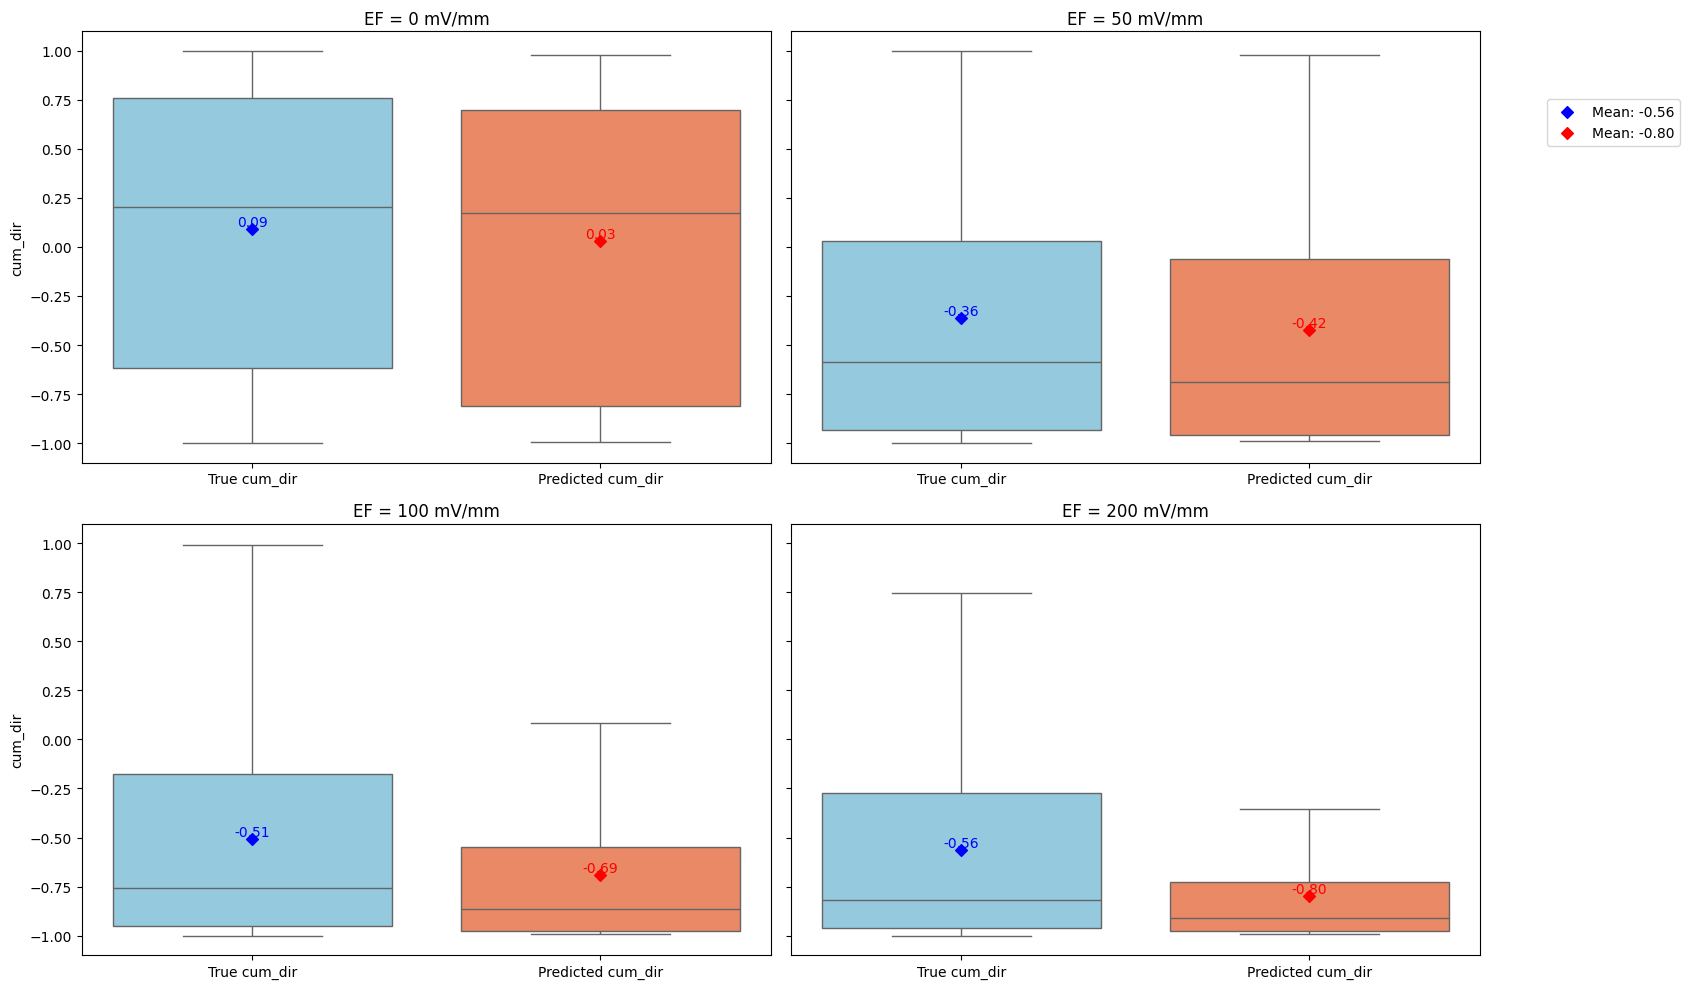

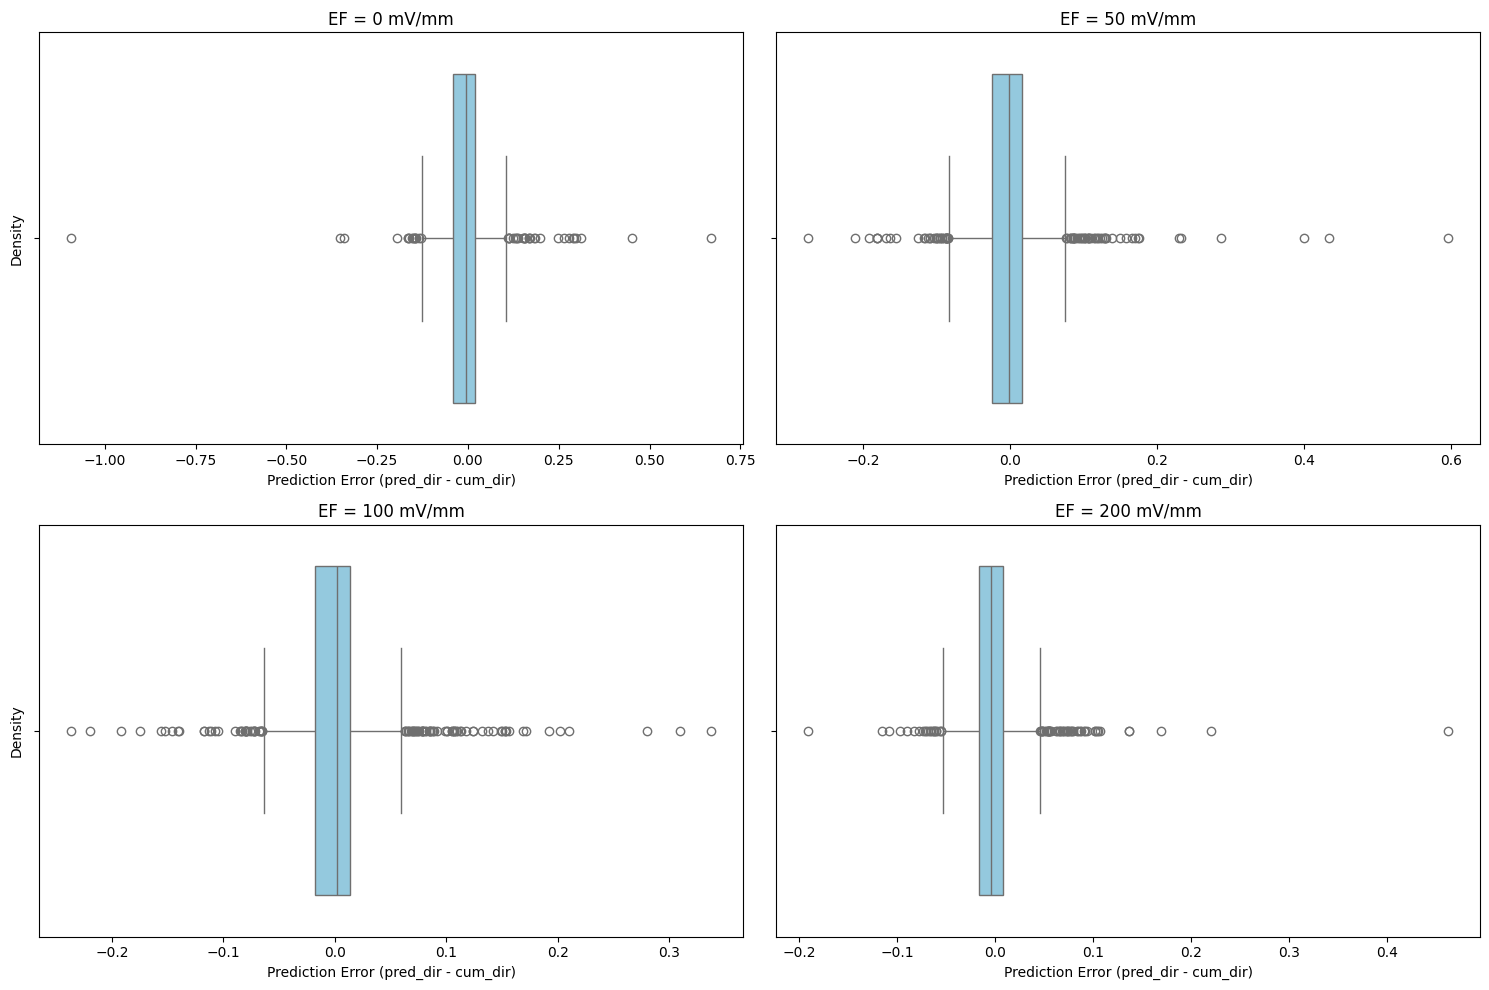

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load the dataframe
df = pd.read_csv('data/cncc_predictions.csv')

# Define the electric field values
efs = [0, 50, 100, 200]

# Create a figure and axes for the box plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each ef value
for i, ef in enumerate(efs):
    # Filter the dataframe for the current ef value
    df_ef = df[df['ef'] == ef]

    # Create a box plot for the error
    sns.boxplot(
        x=df_ef['pred_dir'] - df_ef['cum_dir'],
        ax=axes[i],
        color = 'skyblue'
    )
    axes[i].set_title(f'EF = {ef} mV/mm')
    axes[i].set_xlabel('Prediction Error (pred_dir - cum_dir)')
    axes[i].set_ylabel('Density')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataframe
df = pd.read_csv('data/cncc_predictions.csv')

# Define the electric field values
efs = [0, 50, 100, 200]

# Create a figure and axes for the histograms
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Loop through each ef value
for i, ef in enumerate(efs):
    # Filter the dataframe for the current ef value
    df_ef = df[df['ef'] == ef]

    # Plot the histogram of the error
    axes[i].hist(df_ef['pred_dir']-df_ef['cum_dir'], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'EF = {ef} mV/mm')
    axes[i].set_xlabel('Prediction Error (pred_dir - cum_dir)')
    axes[i].set_ylabel('Frequency')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/cncc_predictions.csv'

# studying noise

In [ ]:
import random
import numpy as np
import tensorflow as tf
import os

# Set random seeds for reproducibility
seed_value = 42 # you can choose any number for your seed
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [ ]:
def add_noise(data, std_dev):
    """Adds Gaussian noise to the input data."""
    noise = np.random.normal(0, std_dev, data.shape)
    return data + noise

In [ ]:
#trains numerous models using a list of numbers to initialize the models
def typical_model(trainX,trainY,valX,valY,testX,testY, epochs=100):

    #build the model
    print('Training model')
    model = Sequential()
    model.add(LSTM(80, input_shape=(20, 2)))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, validation_data=(valX, valY), epochs=epochs, batch_size=1, verbose=1)

    model.save("models/cncc_lstm/model.h5")
    print("Saved model to disk")

    #Predict on training, validation, and test sets
    trainPredict = model.predict(trainX)
    valPredict = model.predict(valX)
    testPredict = model.predict(testX)

    #Calculate RMSEs
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
    print('Training RMSE: {}'.format(trainScore))
    valScore = math.sqrt(mean_squared_error(valY, valPredict))
    print('Validation RMSE: {}'.format(valScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Testing RMSE: {}'.format(testScore))

    preds = {}
    preds["train_pred"] = trainPredict
    preds["val_pred"] = valPredict
    preds["test_pred"] = testPredict

    errors = {}
    errors["train_error"] = trainScore
    errors["val_error"] = valScore
    errors["test_error"] = testScore

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    losses = {}

    losses['loss'] = history.history["loss"]
    losses['val_loss'] = history.history["val_loss"]

    return model, preds, errors, losses

In [ ]:
def create_dataset_noiseTrainX(df, lookback=20, in_cols=['volt', 'cum_dir'], out_cols='cum_dir', efs=[0,50,100,200], tracks=(1,51), noise_std=0):
    trainX, trainY, = [], [] #lists of training and testing inputs/outputs
    for ef in efs:
        for track in range(tracks[0], tracks[1]): # training the model by ef and track
            cell = df.loc[(df["track"] == track)&(df["ef"] == ef)] #all rows of data pertaining to this cell
            cell = cell[in_cols] #reduce it to our columns of interest
            for i in range(len(cell)-lookback-1):
                noisy_data = add_noise(cell[i:i+lookback].to_numpy(), noise_std)
                trainX.append(noisy_data) #adding training groups w overlapping with noise
            cell = cell[out_cols]
            for i in range(len(cell)-lookback-1):
                trainY.append(cell[i+lookback:i+lookback+1]) # one single Y for lookbacks size X (20:1)

    trainX = np.array(list(map(lambda x: x, trainX)))
    trainY = np.array(list(map(lambda x: x.to_numpy(), trainY)))
    return np.array(trainX), np.array(trainY)

In [ ]:
efs = [0, 50, 100, 200]

In [ ]:
trainX, trainY = create_dataset_noiseTrainX(df,efs=efs, tracks=(1,41), noise_std=.5)
trainX

array([[[-0.24463876,  0.46744043],
        [ 0.08454165,  0.44068838],
        [ 0.01138876,  1.07204103],
        ...,
        [-0.67053787,  0.94629651],
        [-0.83117689, -0.17639056],
        [ 0.49280412,  1.69110982]],

       [[ 0.11828485,  1.19601151],
        [-0.56235203,  1.27097792],
        [-0.47519671,  0.18179498],
        ...,
        [-1.01416629,  1.22322283],
        [ 0.22274664,  0.53643007],
        [ 0.20721173,  0.77504349]],

       [[-0.81429036,  0.57283782],
        [-0.76599831,  1.14466104],
        [-0.11257911,  1.07553739],
        ...,
        [-0.99230471, -0.27830816],
        [-0.46634658,  1.18497285],
        [-0.4402825 ,  0.3830258 ]],

       ...,

       [[ 0.0825191 , -0.44857019],
        [-0.29178546, -1.67001333],
        [ 0.77194573, -0.53110387],
        ...,
        [ 1.97812871, -1.63078621],
        [-0.85926443, -0.80529765],
        [ 0.83035432, -1.52503707]],

       [[ 0.42549978,  0.11686088],
        [ 0.31965693, -0.19

In [ ]:
noise_stds = [0, 0.01, 0.05, 0.1, 0.2, 0.5]  # Different standard deviations for noise
results = {} #Dictionary to keep results from various noise levels
testScores = {}

for std_dev in noise_stds:
    print(f"Training model with noise std_dev: {std_dev}")

    # Recreate datasets with noise
    trainX, trainY = create_dataset(df,efs=efs, tracks=(1,41), noise_std=std_dev)
    valX, valY = create_dataset(df, efs=efs, tracks=(41,51), noise_std=std_dev)
    testX, testY = create_dataset(df2, efs=efs, tracks=(1,51), noise_std=std_dev)

    model, prediction, errors = typical_model(trainX,trainY,valX,valY,testX,testY, epochs=50)

    #Calculate RMSE
    testPredict = model.predict(testX) #Predict on test set
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Testing RMSE: {}'.format(testScore))
    testScores[std_dev] = testScore

    results[std_dev] = errors #Store results in dictionary

Training model with noise std_dev: 0
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 0.0458 - val_loss: 0.0111
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0117 - val_loss: 0.0076
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 0.0091 - val_loss: 0.0057
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0086 - val_loss: 0.0055
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 0.0083 - val_loss: 0.0053
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0080 - val_loss: 0.0049
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0072 - val_loss: 0.0046
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0068 - val_loss: 0.0046
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.05692618965086576
Validation RMSE: 0.0662928370711517
Testing RMSE: 0.08864278752006066
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Testing RMSE: 0.08864278752006066
Training model with noise std_dev: 0.01
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0432 - val_loss: 0.0120
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0117 - val_loss: 0.0079
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0099 - val_loss: 0.0061
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.0091 - val_loss: 0.0059
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 0.0087 - val_loss: 0.0057
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0084 - val_loss: 0.0054
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0081 - val_loss: 0.0052
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0078 - val_loss: 0.0050
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0075 - val_loss: 0.0048
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.06010074698100746
Validation RMSE: 0.07164101210924556
Testing RMSE: 0.09559255364212449
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.09559255364212449
Training model with noise std_dev: 0.05
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0435 - val_loss: 0.0118
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0131 - val_loss: 0.0086
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0116 - val_loss: 0.0077
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0110 - val_loss: 0.0072
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0106 - val_loss: 0.0070
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0105 - val_loss: 0.0070
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0102 - val_loss: 0.0068
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0100 - val_loss: 0.0067
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0098 - val_loss: 0.0066
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0097 - val_loss: 0.0068
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0094 - val_loss: 0.0067
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.07701314326881122
Validation RMSE: 0.08395845931707768
Testing RMSE: 0.10089893587042036
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Testing RMSE: 0.10089893587042036
Training model with noise std_dev: 0.1
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0535 - val_loss: 0.0147
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0158 - val_loss: 0.0132
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0147 - val_loss: 0.0125
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0142 - val_loss: 0.0114
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0139 - val_loss: 0.0107
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0137 - val_loss: 0.0106
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0135 - val_loss: 0.0109
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0134 - val_loss: 0.0107
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0131 - val_loss: 0.0106
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - loss: 0.0130 - val_loss: 0.0109
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0129 - val_loss: 0.0109
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Training RMSE: 0.08406112001581016
Validation RMSE: 0.11277531801678747
Testing RMSE: 0.12366255261981943
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.12366255261981943
Training model with noise std_dev: 0.2
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0447 - val_loss: 0.0249
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 0.0226 - val_loss: 0.0233
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0222 - val_loss: 0.0236
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0218 - val_loss: 0.0218
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0215 - val_loss: 0.0212
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0215 - val_loss: 0.0197
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0252 - val_loss: 0.0195
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0208 - val_loss: 0.0195
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0208 - val_loss: 0.0190
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0210 - val_loss: 0.0196
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0200 - val_loss: 0.0189
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Training RMSE: 0.10096909088060457
Validation RMSE: 0.16052610386566452
Testing RMSE: 0.16744871213800921
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.16744871213800921
Training model with noise std_dev: 0.5
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.0616 - val_loss: 0.0586
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0479 - val_loss: 0.0601
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0472 - val_loss: 0.0608
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0466 - val_loss: 0.0607
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 0.0462 - val_loss: 0.0606
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 44s 14ms/step - loss: 0.0458 - val_loss: 0.0596
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0454 - val_loss: 0.0585
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 0.0449 - val_loss: 0.0606
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0444 - val_loss: 0.0596
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0438 - val_loss: 0.0587
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0434 - val_loss: 0.0606
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.12434562708404694
Validation RMSE: 0.26648997406408287
Testing RMSE: 0.26264317584022273
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.26264317584022273


In [ ]:
results

NameError: name 'results' is not defined

In [ ]:
# Convert the dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results)
df_results

,0.00,0.01,0.05,0.10,0.20,0.50
train_error,0.056926,0.060101,0.077013,0.084061,0.100969,0.124346
val_error,0.066293,0.071641,0.083958,0.112775,0.160526,0.266490
test_error,0.088643,0.095593,0.100899,0.123663,0.167449,0.262643


In [ ]:
df_results.to_csv('data/std_results.csv', index=False)

['0.0', '0.01', '0.05', '0.1', '0.2', '0.5']


TypeError: unhashable type: 'list'

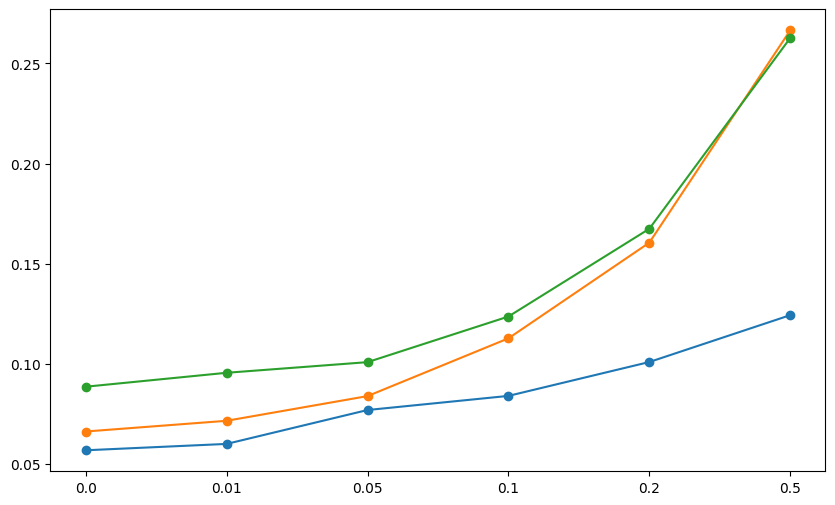

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the DataFrame from the CSV (if it's already saved)
# df_results = pd.read_csv('data/std_results.csv')

# Or if df_results is already in your notebook, use it as it is.
df_results = pd.read_csv('std_results.csv')
# Define the standard deviations from the columns
noise_stds = df_results.columns.tolist()

print(noise_stds)
# Extract error values as a list of lists, for each std
train_errors = df_results.loc[0].tolist()
val_errors = df_results.loc[1].tolist()
test_errors = df_results.loc[2].tolist()

# Set up the plot
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

# Plot the error values for each std_dev
plt.plot(noise_stds, train_errors, marker='o', linestyle='-', label='Train Error')
plt.plot(noise_stds, val_errors, marker='o', linestyle='-', label='Validation Error')
plt.plot(noise_stds, test_errors, marker='o', linestyle='-', label='Test Error')
plt.xscale([0, 0.1, 0.2, 0.3, 0.4, 0.5])
# plt.xticks([0, 0.01, 0.05, 0.1, 0.2, 0.5])
# Add labels and title
plt.xlabel('Standard Deviation of Noise')
plt.ylabel('RMSE')
plt.title('Model Error vs Noise Standard Deviation for input cum_dir')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

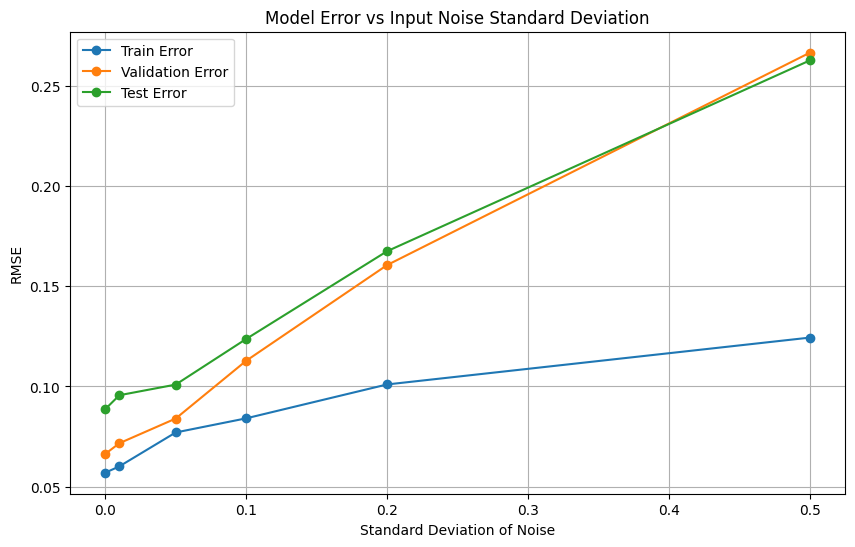

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the DataFrame from the CSV
df_results = pd.read_csv('std_results.csv')

# Define the standard deviations from the columns (ensure they are converted to float)
noise_stds = [float(x) for x in df_results.columns.tolist()]

# Extract error values as a list of lists, for each std
train_errors = df_results.loc[0].tolist()
val_errors = df_results.loc[1].tolist()
test_errors = df_results.loc[2].tolist()

# Set up the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the error values for each std_dev
plt.plot(noise_stds, train_errors, marker='o', linestyle='-', label='Train Error')
plt.plot(noise_stds, val_errors, marker='o', linestyle='-', label='Validation Error')
plt.plot(noise_stds, test_errors, marker='o', linestyle='-', label='Test Error')

# Set x-axis ticks evenly spaced from 0 to 0.5
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

# Add labels and title
plt.xlabel('Standard Deviation of Noise')
plt.ylabel('RMSE')
plt.title('Model Error vs Input Noise Standard Deviation')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# noise only in cum_dir

In [ ]:
def add_noise_to_input_variable(data, std_dev, variable_index):
    """Adds Gaussian noise to a specific column of the input data."""
    noise = np.zeros(data.shape) # initialize noise as an array of zeros
    noise[:, variable_index] = np.random.normal(0, std_dev, data.shape[0]) #add noise only to the chosen column
    return data + noise

In [ ]:
def create_dataset_noise_dir(df, lookback=20, in_cols=['volt', 'cum_dir'], out_cols='cum_dir', efs=[0,50,100,200], tracks=(1,51), noise_std=0, noise_variable='cum_dir'):
    trainX, trainY, = [], [] #lists of training and testing inputs/outputs
    for ef in efs:
        for track in range(tracks[0], tracks[1]): # training the model by ef and track
            cell = df.loc[(df["track"] == track)&(df["ef"] == ef)] #all rows of data pertaining to this cell
            cell = cell[in_cols] #reduce it to our columns of interest

            if noise_variable == 'cum_dir':
              variable_index = 1
            elif noise_variable == 'volt':
                variable_index = 0
            else:
                raise ValueError("noise_variable must be 'cum_dir' or 'volt'")

            for i in range(len(cell)-lookback-1):
                noisy_data = add_noise_to_input_variable(cell[i:i+lookback].to_numpy(), noise_std, variable_index)
                trainX.append(noisy_data) #adding training groups w overlapping with noise
            cell = cell[out_cols]
            for i in range(len(cell)-lookback-1):
                trainY.append(cell[i+lookback:i+lookback+1]) # one single Y for lookbacks size X (20:1)

    trainX = np.array(list(map(lambda x: x, trainX)))
    trainY = np.array(list(map(lambda x: x.to_numpy(), trainY)))
    return np.array(trainX), np.array(trainY)

In [ ]:
df[['volt', 'cum_dir']]

,volt,cum_dir
0,0.0,0.000000
1,0.0,0.989947
2,0.0,0.986390
3,0.0,0.989947
4,0.0,0.967617
...,...,...
12982,0.2,-0.986485
12983,0.2,-0.982570
12984,0.2,-0.981313
12985,0.2,-0.976336


In [ ]:
trainX, trainY = create_dataset_noise_dir(df,efs=efs, tracks=(1,41), noise_std=.2, noise_variable='cum_dir')
trainX

array([[[ 0.        ,  0.1263518 ],
        [ 0.        ,  1.11452438],
        [ 0.        ,  1.07693123],
        ...,
        [ 0.        ,  0.71673286],
        [ 0.        ,  0.66749723],
        [ 0.        ,  0.76698865]],

       [[ 0.        ,  0.94871215],
        [ 0.        ,  0.86948802],
        [ 0.        ,  0.99489959],
        ...,
        [ 0.        ,  0.62395207],
        [ 0.        ,  1.07293884],
        [ 0.        ,  0.76862414]],

       [[ 0.        ,  1.15840527],
        [ 0.        ,  0.41815848],
        [ 0.        ,  0.77526751],
        ...,
        [ 0.        ,  1.16440455],
        [ 0.        ,  0.88108742],
        [ 0.        ,  1.00719121]],

       ...,

       [[ 0.2       , -1.00765041],
        [ 0.2       , -0.68885034],
        [ 0.2       , -0.44516999],
        ...,
        [ 0.2       , -0.76644254],
        [ 0.2       , -0.64589154],
        [ 0.2       , -1.04511671]],

       [[ 0.2       , -1.08619654],
        [ 0.2       , -1.21

In [ ]:
noise_stds = [0, 0.01, 0.05, 0.1, 0.2, 0.5]  # Different standard deviations for noise
results = {} #Dictionary to keep results from various noise levels
testScores = {}

for std_dev in noise_stds:
    print(f"Training model with noise std_dev: {std_dev}")

    # Recreate datasets with noise
    trainX, trainY = create_dataset(df,efs=efs, tracks=(1,41), noise_std=std_dev)
    valX, valY = create_dataset(df, efs=efs, tracks=(41,51), noise_std=std_dev)
    testX, testY = create_dataset(df2, efs=efs, tracks=(1,51), noise_std=std_dev)

    model, prediction, errors = typical_model(trainX,trainY,valX,valY,testX,testY, epochs=50)

    #Calculate RMSE
    testPredict = model.predict(testX) #Predict on test set
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Testing RMSE: {}'.format(testScore))
    testScores[std_dev] = testScore

    results[std_dev] = errors #Store results in dictionary

Training model with noise std_dev: 0
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0464 - val_loss: 0.0116
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0118 - val_loss: 0.0075
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0099 - val_loss: 0.0057
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0091 - val_loss: 0.0058
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0086 - val_loss: 0.0052
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0083 - val_loss: 0.0052
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0081 - val_loss: 0.0048
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0077 - val_loss: 0.0046
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0074 - val_loss: 0.0046
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0071 - val_loss: 0.0045
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0065 - val_loss: 0.0045
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.05894765648978073
Validation RMSE: 0.06736295250711674
Testing RMSE: 0.08734215275589162
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.08734215275589162
Training model with noise std_dev: 0.01
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0476 - val_loss: 0.0121
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0119 - val_loss: 0.0080
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0100 - val_loss: 0.0061
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0083 - val_loss: 0.0052
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0080 - val_loss: 0.0052
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0078 - val_loss: 0.0050
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0076 - val_loss: 0.0049
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 0.0066 - val_loss: 0.0050
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.06311030752967708
Validation RMSE: 0.06694619216801126
Testing RMSE: 0.08894973223171686
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.08894973223171686
Training model with noise std_dev: 0.05
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.0369 - val_loss: 0.0136
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0127 - val_loss: 0.0091
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0113 - val_loss: 0.0078
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0108 - val_loss: 0.0073
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0105 - val_loss: 0.0071
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0104 - val_loss: 0.0070
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0101 - val_loss: 0.0069
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0099 - val_loss: 0.0070
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0100 - val_loss: 0.0069
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0099 - val_loss: 0.0069
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0097 - val_loss: 0.0070
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.07042208505764785
Validation RMSE: 0.08323149987999229
Testing RMSE: 0.10280560555287578
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.10280560555287578
Training model with noise std_dev: 0.1
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.0447 - val_loss: 0.0161
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0157 - val_loss: 0.0156
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0146 - val_loss: 0.0132
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0138 - val_loss: 0.0120
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0135 - val_loss: 0.0117
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0133 - val_loss: 0.0113
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0132 - val_loss: 0.0113
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0131 - val_loss: 0.0112
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0130 - val_loss: 0.0114
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0128 - val_loss: 0.0113
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - loss: 0.0126 - val_loss: 0.0112
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Training RMSE: 0.09020083076206097
Validation RMSE: 0.09740402515293595
Testing RMSE: 0.12225481906529917
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Testing RMSE: 0.12225481906529917
Training model with noise std_dev: 0.2
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0455 - val_loss: 0.0297
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.0214 - val_loss: 0.0242
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0206 - val_loss: 0.0206
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0201 - val_loss: 0.0196
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - loss: 0.0198 - val_loss: 0.0189
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0195 - val_loss: 0.0183
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0193 - val_loss: 0.0190
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0193 - val_loss: 0.0197
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0191 - val_loss: 0.0185
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 0.0194 - val_loss: 0.0185
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.0188 - val_loss: 0.0189
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.10827690090030068
Validation RMSE: 0.14580117238731388
Testing RMSE: 0.1629323345285093
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.1629323345285093
Training model with noise std_dev: 0.5
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0681 - val_loss: 0.0666
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0460 - val_loss: 0.0655
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0454 - val_loss: 0.0635
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0449 - val_loss: 0.0616
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0445 - val_loss: 0.0602
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0441 - val_loss: 0.0584
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0437 - val_loss: 0.0578
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0433 - val_loss: 0.0585
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0428 - val_loss: 0.0585
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - loss: 0.0425 - val_loss: 0.0579
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0424 - val_loss: 0.0567
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.15759302277639675
Validation RMSE: 0.22568165194629083
Testing RMSE: 0.24438179186856004
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.24438179186856004


In [ ]:
# Convert the dictionary to a DataFrame
df_results_dir = pd.DataFrame.from_dict(results)
df_results_dir

,0.00,0.01,0.05,0.10,0.20,0.50
train_error,0.058948,0.063110,0.070422,0.090201,0.108277,0.157593
val_error,0.067363,0.066946,0.083231,0.097404,0.145801,0.225682
test_error,0.087342,0.088950,0.102806,0.122255,0.162932,0.244382


In [ ]:
df_results.to_csv('data/std_results_dir.csv', index=False)

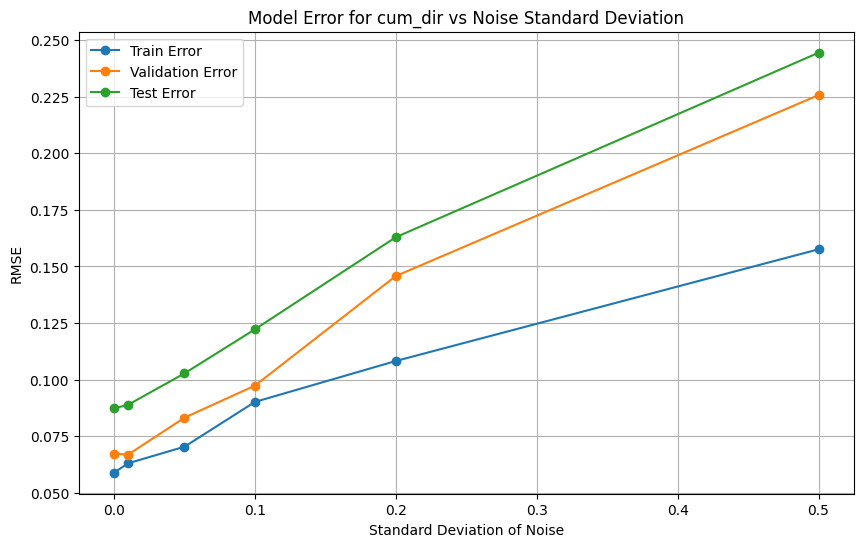

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the DataFrame from the CSV (if it's already saved)
# df_results = pd.read_csv('data/std_results.csv')

# Or if df_results is already in your notebook, use it as it is.

# Define the standard deviations from the columns
noise_stds = df_results_dir.columns.tolist()

# Extract error values as a list of lists, for each std
train_errors = df_results_dir.loc['train_error'].tolist()
val_errors = df_results_dir.loc['val_error'].tolist()
test_errors = df_results_dir.loc['test_error'].tolist()

# Set up the plot
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

# Plot the error values for each std_dev
plt.plot(noise_stds, train_errors, marker='o', linestyle='-', label='Train Error')
plt.plot(noise_stds, val_errors, marker='o', linestyle='-', label='Validation Error')
plt.plot(noise_stds, test_errors, marker='o', linestyle='-', label='Test Error')

# Add labels and title
plt.xlabel('Standard Deviation of Noise')
plt.ylabel('RMSE')
plt.title('Model Error for cum_dir vs Noise Standard Deviation')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

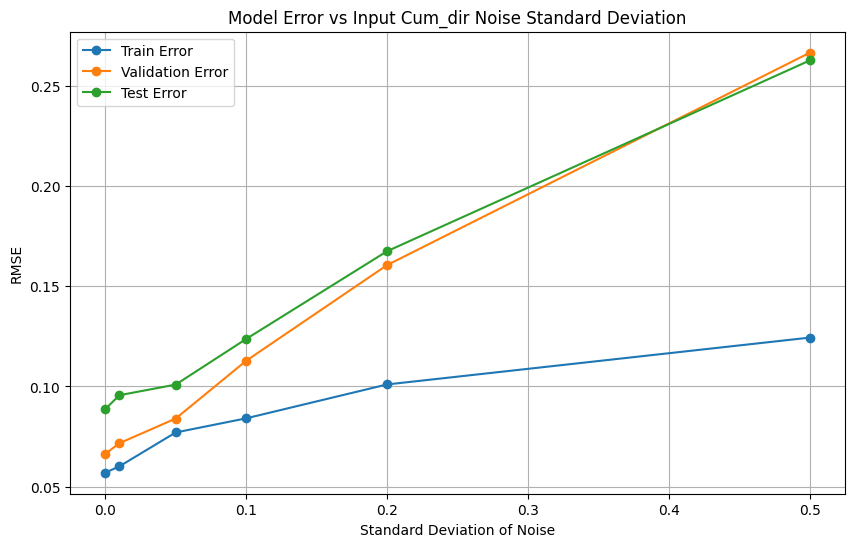

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the DataFrame from the CSV
df_results_dir = pd.read_csv('std_results_dir.csv')

# Define the standard deviations from the columns (ensure they are converted to float)
noise_stds = [float(x) for x in df_results.columns.tolist()]

# Extract error values as a list of lists, for each std
train_errors = df_results_dir.loc[0].tolist()
val_errors = df_results_dir.loc[1].tolist()
test_errors = df_results_dir.loc[2].tolist()

# Set up the plot
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the error values for each std_dev
plt.plot(noise_stds, train_errors, marker='o', linestyle='-', label='Train Error')
plt.plot(noise_stds, val_errors, marker='o', linestyle='-', label='Validation Error')
plt.plot(noise_stds, test_errors, marker='o', linestyle='-', label='Test Error')

# Set x-axis ticks evenly spaced from 0 to 0.5
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

# Add labels and title
plt.xlabel('Standard Deviation of Noise')
plt.ylabel('RMSE')
plt.title('Model Error vs Input Cum_dir Noise Standard Deviation')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# adding noise to the output

In [ ]:
def add_noise(data, std_dev):
    """Adds Gaussian noise to the input data."""
    noise = np.random.normal(0, std_dev, data.shape)
    return data + noise

In [ ]:
def create_dataset_noiseTrainY(df, lookback=20, in_cols=['volt', 'cum_dir'], out_cols='cum_dir', efs=[0, 50, 100, 200], tracks=(1, 51), noise_std=0):
    trainX, trainY, = [], []  # lists of training and testing inputs/outputs
    for ef in efs:
        for track in range(tracks[0], tracks[1]):  # training the model by ef and track
            cell = df.loc[(df["track"] == track) & (df["ef"] == ef)]  # all rows of data pertaining to this cell
            cell = cell[in_cols]  # reduce it to our columns of interest
            for i in range(len(cell) - lookback - 1):
                trainX.append(cell[i:i + lookback])  # adding training groups w overlapping
            cell = df.loc[(df["track"] == track) & (df["ef"] == ef)]  # all rows of data pertaining to this cell
            cell = cell[out_cols] #reduce it to our column of interest
            for i in range(len(cell) - lookback - 1):
                noisy_output = add_noise(cell[i + lookback:i + lookback + 1].to_numpy(), noise_std)
                trainY.append(noisy_output)  # one single Y for lookbacks size X (20:1)

    trainX = np.array(list(map(lambda x: x.to_numpy(), trainX)))
    trainY = np.array(list(map(lambda x: x, trainY)))
    return np.array(trainX), np.array(trainY)

In [ ]:
noise_stds = [0, 0.01, 0.05, 0.1, 0.2, 0.5]  # Different standard deviations for noise
results = {} #Dictionary to keep results from various noise levels
testScores = {}
losses = {}

for std_dev in noise_stds:
    print(f"Training model with noise std_dev: {std_dev}")

    # Recreate datasets with noise
    trainX, trainY = create_dataset_noiseTrainY(df,efs=efs, tracks=(1,41), noise_std=std_dev)
    valX, valY = create_dataset_noiseTrainY(df, efs=efs, tracks=(41,51), noise_std=std_dev)
    testX, testY = create_dataset_noiseTrainY(df2, efs=efs, tracks=(1,51), noise_std=std_dev)

    model, prediction, errors, loss = typical_model(trainX,trainY,valX,valY,testX,testY, epochs=50)

    #Calculate RMSE
    testPredict = model.predict(testX) #Predict on test set
    testScore = math.sqrt(mean_squared_error(testY, testPredict))
    print('Testing RMSE: {}'.format(testScore))
    testScores[std_dev] = testScore

    losses[std_dev] = loss #Store results in dictionary
    results[std_dev] = errors #Store results in dictionary

Training model with noise std_dev: 0
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0458 - val_loss: 0.0111
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0117 - val_loss: 0.0076
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0099 - val_loss: 0.0060
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.0091 - val_loss: 0.0057
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0086 - val_loss: 0.0055
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.0083 - val_loss: 0.0053
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: 0.0080 - val_loss: 0.0049
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 0.0072 - val_loss: 0.0046
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - loss: 0.0068 - val_loss: 0.0046
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.0064 - val_loss: 0.0045
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Training RMSE: 0.05692618965086576
Validation RMSE: 0.0662928370711517
Testing RMSE: 0.08864278752006066
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing RMSE: 0.08864278752006066
Training model with noise std_dev: 0.01
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.0433 - val_loss: 0.0116
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0118 - val_loss: 0.0077
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - loss: 0.0099 - val_loss: 0.0059
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0092 - val_loss: 0.0058
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.0083 - val_loss: 0.0052
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.0081 - val_loss: 0.0049
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0077 - val_loss: 0.0048
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.0074 - val_loss: 0.0047
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0069 - val_loss: 0.0048
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0066 - val_loss: 0.0048
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Training RMSE: 0.060001618282228344
Validation RMSE: 0.07075493698937363
Testing RMSE: 0.09208773233534283
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Testing RMSE: 0.09208773233534283
Training model with noise std_dev: 0.05
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 0.0458 - val_loss: 0.0143
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0145 - val_loss: 0.0112
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - loss: 0.0127 - val_loss: 0.0096
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0119 - val_loss: 0.0091
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - loss: 0.0113 - val_loss: 0.0081
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 0.0110 - val_loss: 0.0080
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0107 - val_loss: 0.0078
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0104 - val_loss: 0.0077
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0099 - val_loss: 0.0079
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - loss: 0.0095 - val_loss: 0.0082
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.08222061572328408
Validation RMSE: 0.08669508411934569
Testing RMSE: 0.1151438719312158
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing RMSE: 0.1151438719312158
Training model with noise std_dev: 0.1
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0639 - val_loss: 0.0225
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0230 - val_loss: 0.0189
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0211 - val_loss: 0.0168
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0202 - val_loss: 0.0161
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.0199 - val_loss: 0.0157
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - loss: 0.0196 - val_loss: 0.0153
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 36s 11ms/step - loss: 0.0193 - val_loss: 0.0152
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0190 - val_loss: 0.0150
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.0188 - val_loss: 0.0149
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 0.0185 - val_loss: 0.0149
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0180 - val_loss: 0.0147
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Training RMSE: 0.1174735557273387
Validation RMSE: 0.12781938288805986
Testing RMSE: 0.13870827200368482
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing RMSE: 0.13870827200368482
Training model with noise std_dev: 0.2
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.0762 - val_loss: 0.0591
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0522 - val_loss: 0.0560
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.0509 - val_loss: 0.0545
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.0498 - val_loss: 0.0537
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.0489 - val_loss: 0.0527
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 0.0482 - val_loss: 0.0523
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.0477 - val_loss: 0.0523
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.0472 - val_loss: 0.0523
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - loss: 0.0474 - val_loss: 0.0524
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0458 - val_loss: 0.0521
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0459 - val_loss: 0.0525
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Training RMSE: 0.20291226133541923
Validation RMSE: 0.2357473076840936
Testing RMSE: 0.22805833423606428
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Testing RMSE: 0.22805833423606428
Training model with noise std_dev: 0.5
Training model
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2560/2560 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - loss: 0.2797 - val_loss: 0.2460
Epoch 2/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.2473 - val_loss: 0.2428
Epoch 3/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.2450 - val_loss: 0.2406
Epoch 4/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.2429 - val_loss: 0.2399
Epoch 5/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.2414 - val_loss: 0.2365
Epoch 6/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 0.2402 - val_loss: 0.2346
Epoch 7/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.2387 - val_loss: 0.2332
Epoch 8/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.2375 - val_loss: 0.2335
Epoch 9/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.2369 - val_loss: 0.2311
Epoch 10/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - loss: 0.2366 - val_loss: 0.2306
Epoch 11/50
2560/2560 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.2363 - val_loss: 0.2312
Epoch 12/50
2560/25

Saved model to disk
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Training RMSE: 0.5408935008306894
Validation RMSE: 0.49970916438479346
Testing RMSE: 0.5326403302002986
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Testing RMSE: 0.5326403302002986


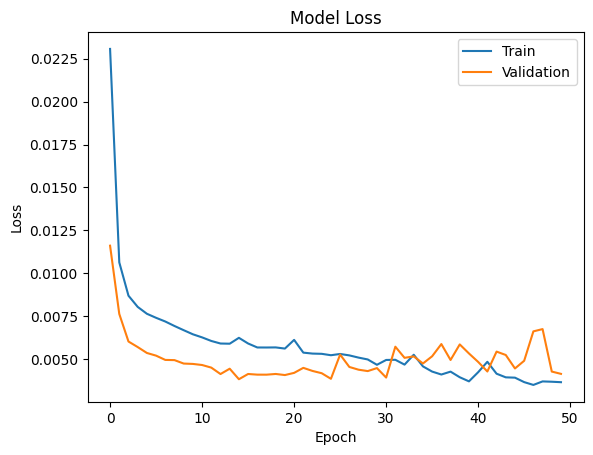

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Convert the dictionary to a DataFrame
df_results_output = pd.DataFrame.from_dict(results)
df_results_output

,0.00,0.01,0.05,0.10,0.20,0.50
train_error,0.056926,0.060002,0.082221,0.117474,0.202912,0.540894
val_error,0.066293,0.070755,0.086695,0.127819,0.235747,0.499709
test_error,0.088643,0.092088,0.115144,0.138708,0.228058,0.532640


In [ ]:
df_results_output.to_csv('data/std_results_output.csv', index=False)

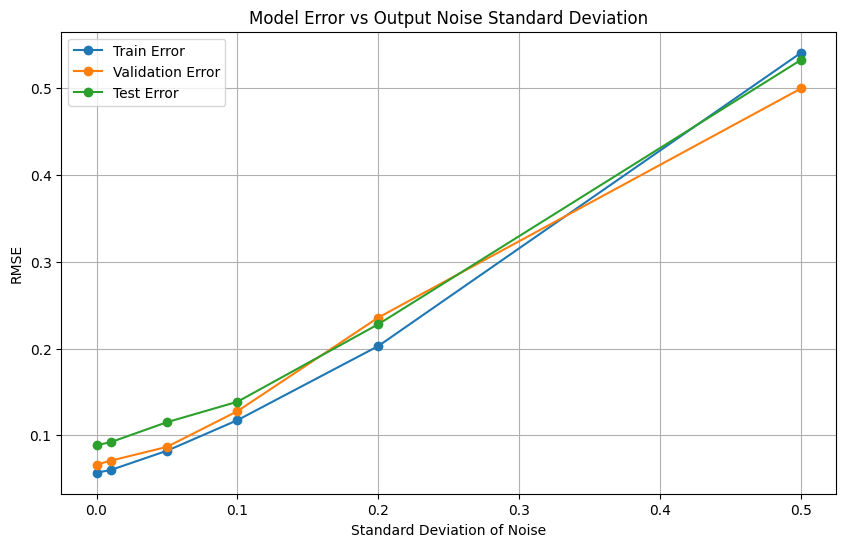

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the DataFrame from the CSV (if it's already saved)
# df_results = pd.read_csv('data/std_results.csv')

# Or if df_results is already in your notebook, use it as it is.

# Define the standard deviations from the columns
noise_stds = df_results_output.columns.tolist()

# Extract error values as a list of lists, for each std
train_errors = df_results_output.loc['train_error'].tolist()
val_errors = df_results_output.loc['val_error'].tolist()
test_errors = df_results_output.loc['test_error'].tolist()

# Set up the plot
plt.figure(figsize=(10, 6))  # Set the figure size (optional)

# Plot the error values for each std_dev
plt.plot(noise_stds, train_errors, marker='o', linestyle='-', label='Train Error')
plt.plot(noise_stds, val_errors, marker='o', linestyle='-', label='Validation Error')
plt.plot(noise_stds, test_errors, marker='o', linestyle='-', label='Test Error')

# Add labels and title
plt.xlabel('Standard Deviation of Noise')
plt.ylabel('RMSE')
plt.title('Model Error vs Output Noise Standard Deviation')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

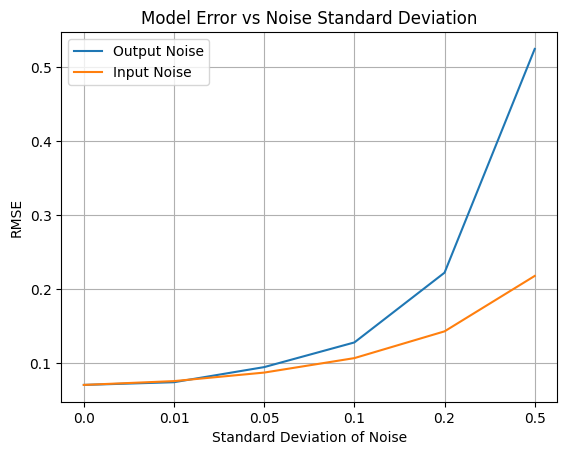

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_output = pd.read_csv('/content/std_results_output.csv')
df_output = df_output.mean()

df_input = pd.read_csv('/content/std_results_dir.csv')
df_input = df_input.mean()

plt.plot(df_output.index, df_output.values, label='Output Noise')
plt.plot(df_input.index, df_input.values, label='Input Noise')
plt.xlabel('Standard Deviation of Noise')
plt.ylabel('RMSE')
plt.title('Model Error vs Noise Standard Deviation')
plt.legend()
plt.grid(True)
plt.show()

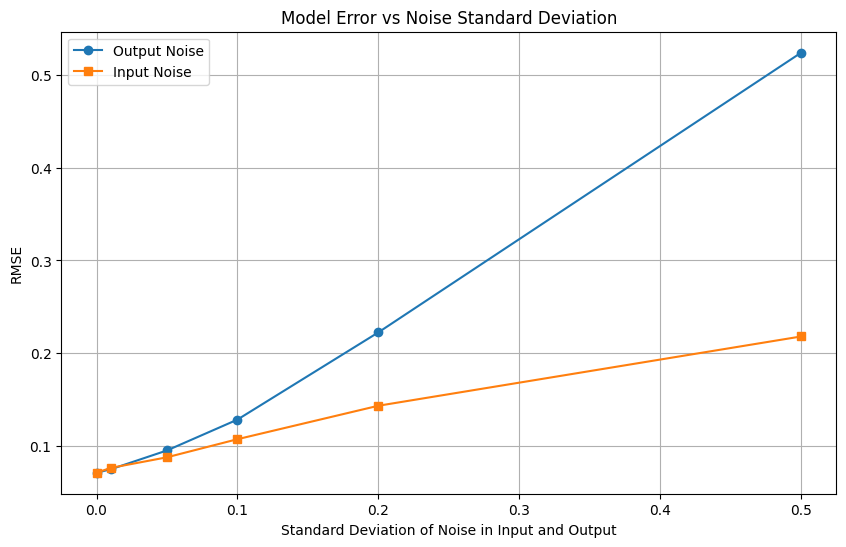

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and compute mean values
df_output = pd.read_csv('/content/std_results_output.csv').mean()
df_input = pd.read_csv('/content/std_results_dir.csv').mean()

# Convert index to numeric values (ensuring correct x-axis representation)
x_values = [0, 0.01, 0.05, 0.1, 0.2, 0.5]  # Assuming index is standard deviation values

# Plot the data
plt.figure(figsize=(10, 6))  # Set figure size

plt.plot(x_values, df_output.values, marker='o', linestyle='-', label='Output Noise')
plt.plot(x_values, df_input.values, marker='s', linestyle='-', label='Input Noise')

# Ensure x-axis is evenly spaced from 0 to 0.5
# plt.xticks(np.logspace(0, -1, 5))

# Add labels and title
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

# Correct xlabel
plt.xlabel('Standard Deviation of Noise in Input and Output')

# Add ylabel, title, legend, and grid
plt.ylabel('RMSE')
plt.title('Model Error vs Noise Standard Deviation')
plt.legend()
plt.grid(True)

# Show plot
plt.show()
